# Sprint データセット作成

In [17]:
import numpy as np
import glob
import re

from PIL import Image
import cv2

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam
from keras import backend as K

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from albumentations import (
    HorizontalFlip, ShiftScaleRotate,RandomRotate90, Blur,Compose,  RGBShift, VerticalFlip, BboxParams,)

from xml.etree import ElementTree

# 【問題1】自作データセットでの分類の学習
自作のデータセットに対して分類問題を解いてください。任意の実装を使用してください。

In [3]:
path = './data_setDC/'
img_list = glob.glob(path + '/*' + ".jpg")
img_list

['./data_setDC/cat_1.jpg',
 './data_setDC/cat_2.jpg',
 './data_setDC/cat_3.jpg',
 './data_setDC/cat_4.jpg',
 './data_setDC/cat_5.jpg',
 './data_setDC/dog_5.jpg',
 './data_setDC/dog_4.jpg',
 './data_setDC/dog_1.jpg',
 './data_setDC/dog_3.jpg',
 './data_setDC/dog_2.jpg']

In [4]:
dog_image_array = np.empty((0, 224, 224, 3))
cat_image_array=np.empty((0, 224, 224,3))
for img in img_list:
    if re.search("dog", img):
        
        dog_img = Image.open(img)
        dog_img = dog_img.resize((224, 224))
        dog_img = np.array(dog_img)
        dog_img = dog_img / 225.0
        dog_img = dog_img.reshape((1, 224, 224, 3))
        dog_image_array = np.concatenate([dog_image_array, dog_img], axis=0)
        
    if re.search("cat", img):
        
        cat_img = Image.open(img)
        cat_img = cat_img.resize((224, 224))
        cat_img = np.array(cat_img)
        cat_img = cat_img / 225.0
        cat_img = cat_img.reshape((1, 224, 224, 3))
        cat_image_array = np.concatenate([cat_image_array, cat_img], axis=0)
        
X = np.concatenate([dog_image_array, cat_image_array], axis=0)

dog_label = np.zeros(5)
cat_label = np.ones(5)
t = np.concatenate([dog_label, cat_label], axis=0)

In [5]:
K.clear_session()
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation="relu", input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(200, activation="relu"))
model.add(Dense(1, activation="softmax"))
model.compile( loss="binary_crossentropy",
    optimizer=Adam(lr=0.01),
    metrics=["accuracy"])
model.summary()

history = model.fit(X, t, epochs=10,verbose=1)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 394272)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               78854600  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 78,855,697
Trainable params: 78,855,697
Non-trainable params: 0
_________________________________________________________________
Epoch 1

# 【問題2】分類データセットに対するデータ拡張
データ拡張（Data Augmentation）を行ってください。

In [7]:
def data_aug(img_list):
    """
    データの拡張を行う関数
    データのパスを受け取り、変化させた画像をnp.arrayの形で返す
    """
    result_array = np.empty((0, 224,224,3))
    
    hori = HorizontalFlip(p=1)
    blur = Blur()
    shift = RGBShift()
    rota = ShiftScaleRotate()
    
    
    for img in img_list:
        image = cv2.imread(img)
        image = cv2.resize(image, (224,224))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        image_original = (image / 225.0).reshape(1, 224 ,224 , 3)
        image_hori = (hori(image=image)["image"] / 225.0).reshape(1, 224, 224, 3)
        image_blur = (blur(image=image)["image"] / 225.0).reshape(1, 224, 224, 3)
        image_shift = (shift(image=image)["image"] / 225.0).reshape(1, 224, 224, 3)
        image_rota = (rota(image=image)["image"] / 225.0).reshape(1, 224, 224, 3)
        
        result_array = np.concatenate([result_array, image_original, image_hori, image_blur, image_shift, image_rota], axis=0)
        
    return result_array

In [11]:
X_aug = data_aug(img_list)
X_aug.shape

(50, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


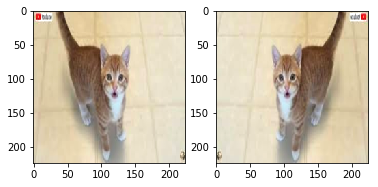

In [16]:
#確認
plt.subplot(1, 2, 1)
plt.imshow(X_aug[0])

plt.subplot(1, 2, 2)
plt.imshow(X_aug[1])

plt.show()

# 【問題3】物体検出データセットの用意
次に、物体検出を行います。バウンディングボックスのアノテーションを行い物体検出のためのデータセットを作成してください。

LabelImgを用いてアノテーションを行なった

# 【問題4】物体検出データセットに対するデータ拡張
データ拡張（Data Augmentation）を行ってください。前述のalbumentationsはバウンディングボックスを合わせての加工が可能です。

In [29]:
def get_ann_array(ann_list):
    """
    xmlからbboxのxmin, ymin, xmax, ymaxを取得する
    """
    cord_bbox = np.empty((0, 4))
    for ann in ann_list:
        tree = ElementTree.parse(ann)
        root = tree.getroot()
        data = root.find('object').find("bndbox")
        
        xmin = int(data.find("xmin").text)
        ymin = int(data.find("ymin").text)
        xmax = int(data.find("xmax").text)
        ymax = int(data.find("ymax").text)
        
        bbox_array = np.array([xmin, ymin, xmax, ymax]).reshape(1, 4)
        cord_bbox = np.concatenate([cord_bbox, bbox_array], axis=0)
    return cord_bbox

In [22]:
def img2array(img_list):
    """
    パスから画像のarrayを取得
    """
    array = np.empty((0, 224,224, 3))
    for img in img_list:
        image = cv2.imread(img)
        image = cv2.resize(image, (224,224))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.reshape(1, 224,224,3)
        
        array = np.concatenate([array, image], axis=0)
    return array

In [24]:
def get_aug(aug, min_area=0., min_visibility=0.):
    return Compose(aug, bbox_params=BboxParams(format='pascal_voc', min_area=min_area, 
                                               min_visibility=min_visibility, label_fields=['category_id']))

In [25]:
def aug_object(image_data, ann_data):
    """
    画像データとbboxesの水増しを行う
    ---------------------------------------------
    input
    image_data: np.ndarray
    ann_data:np.ndarray
    ---------------------------------------------
    output
    result_data_array:np.ndarray
    result_ann_array:np.ndarray
    
    """
    #結果を入れる箱を用意
    result_data_array = np.empty((0, 224,224,3))
    result_ann_array = np.zeros((0, 4))
    


    for i in range(image_data.shape[0]):
        #変化させるクラスをインスタンス化
        hori = get_aug([HorizontalFlip(p=1)])
        var = get_aug([VerticalFlip(p=1)])
        shift= get_aug([RandomRotate90(p=1)])
        fli = get_aug([Blur(p=1)])
        
        #上から５つが猫なので、分類する
        if i <= 4:
            annotations = {'image':image_data[i] , 'bboxes': [ann_data[i]], 'category_id': [1]}
        else:
             annotations = {'image':image_data[i] , 'bboxes': [ann_data[i]], 'category_id': [0]}
            
        #それぞれ変化させる
        image_hori = hori(**annotations)
        image_var = var(**annotations)
        image_shift = shift(**annotations)
        image_fli = fli(**annotations)
        
        #変化させた画像をnp.arrayの形で取り出し、結果を入れる箱に合うようにrehape
        im = image_data[i].reshape(1, 224, 224, 3)
        im_hori = image_hori["image"].reshape(1, 224, 224, 3)
        im_var = image_var["image"].reshape(1, 224, 224, 3)
        im_shift = image_shift["image"].reshape(1, 224, 224, 3)
        im_fli = image_fli["image"].reshape(1, 224, 224, 3)
        
        #変化させたbboxを取り出し、結果を入れる箱に合うようにreshape
        an = ann_data[i].reshape(1, 4)
        an_hori = np.array(image_hori["bboxes"]).reshape(1, 4)
        an_var = np.array(image_var["bboxes"]).reshape(1, 4)
        an_shift = np.array(image_shift["bboxes"]).reshape(1, 4)
        an_fli = np.array(image_fli["bboxes"]).reshape(1, 4)
        
        result_data_array = np.concatenate([result_data_array, im, im_hori, im_var, im_shift, im_fli], axis=0)
        result_ann_array = np.concatenate([result_ann_array, an, an_hori, an_var, an_shift, an_fli], axis=0)
        
    
    return result_data_array, result_ann_array

In [27]:
def im_show(img_data, ann_data, num):
    """
    画像データにbboxを表示したものを返す
    """
    x_min, y_min, x_max, y_max = aug_ann[num].reshape(4,)
    show_img_box = cv2.rectangle(aug_img[num].astype(np.uint8), (int(x_min), int(y_min)), (int(x_max), int(y_max)), color=(255,0,0), thickness = 2)
    return show_img_box

In [18]:
#アノテーションしたファイルのパス取得
p = "./annotation_pascal/"
ann_list = glob.glob(p  + '/*' + ".xml")
ann_list

['./annotation_pascal/cat_1.xml',
 './annotation_pascal/cat_2.xml',
 './annotation_pascal/cat_3.xml',
 './annotation_pascal/cat_4.xml',
 './annotation_pascal/cat_5.xml',
 './annotation_pascal/dog_5.xml',
 './annotation_pascal/dog_4.xml',
 './annotation_pascal/dog_1.xml',
 './annotation_pascal/dog_3.xml',
 './annotation_pascal/dog_2.xml']

In [21]:
#アノテーションした後のxmlからbboxの座標を取得
cord_bbox = get_ann_array(ann_list)
cord_bbox

array([[ 31.,   4., 145., 220.],
       [ 79.,   4., 218., 222.],
       [ 27.,  36., 153., 207.],
       [ 58.,   1., 169., 222.],
       [ 27.,   2., 126., 221.],
       [ 69.,   4., 218., 212.],
       [ 45.,   9., 206., 220.],
       [ 75.,  25., 149., 208.],
       [ 41.,   2., 185., 219.],
       [114.,  22., 193., 214.]])

In [23]:
#リストから画像のarrayを取得
#255で割っていない
X_data = img2array(img_list)

In [26]:
#データの水増し
aug_img, aug_ann = aug_object(X_data, cord_bbox)

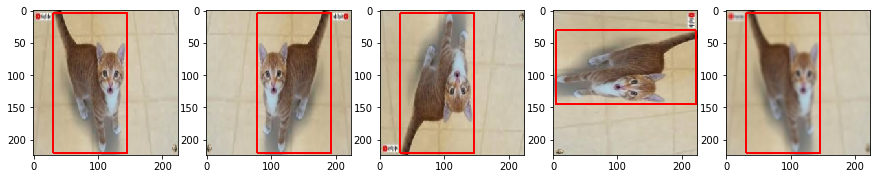

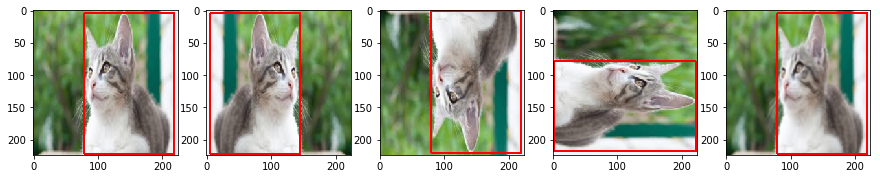

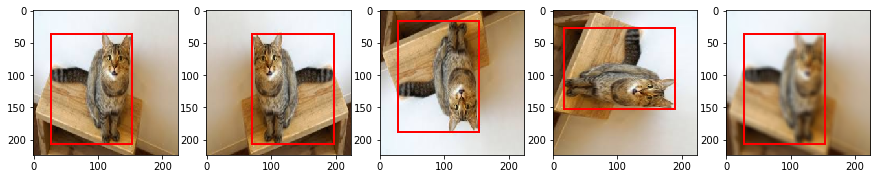

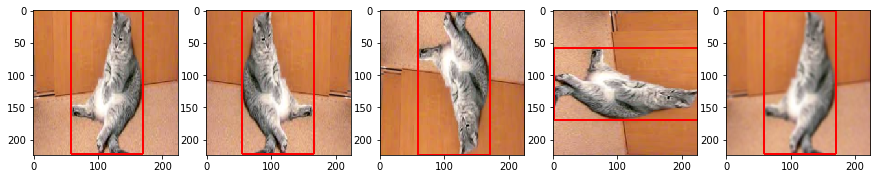

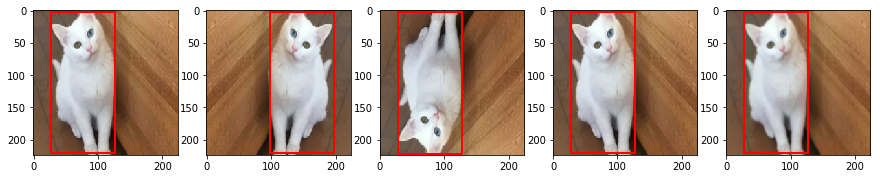

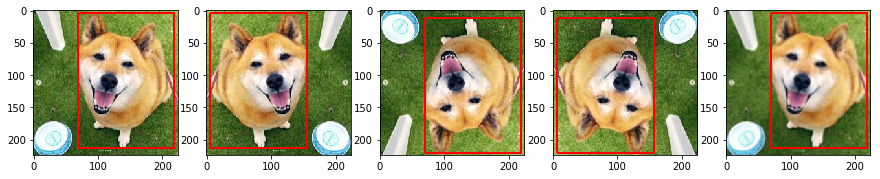

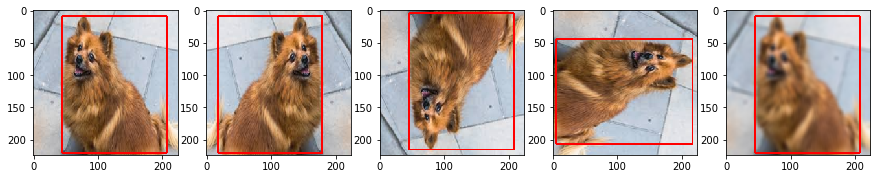

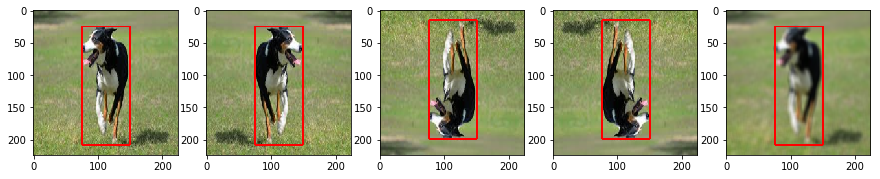

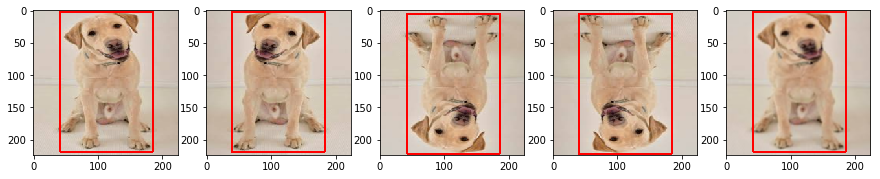

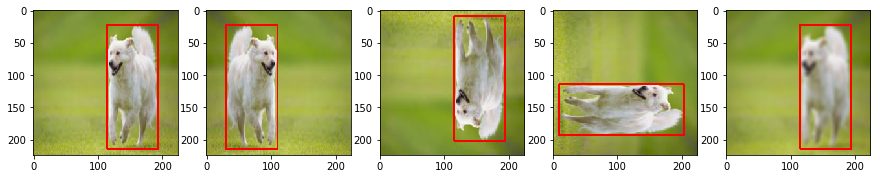

In [28]:
#確認
j = 0
for i in range(10):
    plt.figure(figsize=(15, 10))
    image = im_show(aug_img, aug_ann, i+j)
    plt.subplot(1, 5, 1)
    plt.imshow(image)
    
    image = im_show(aug_img, aug_ann, i+1+j)
    plt.subplot(1, 5, 2)
    plt.imshow(image)
    
    image = im_show(aug_img, aug_ann, i+2+j)
    plt.subplot(1, 5, 3)
    plt.imshow(image)
    
    image = im_show(aug_img, aug_ann, i+3+j)
    plt.subplot(1, 5, 4)
    plt.imshow(image)
    
    image = im_show(aug_img, aug_ann, i+4+j)
    plt.subplot(1, 5, 5)
    plt.imshow(image)
    
    j += 4
    
    plt.show()